The two questions that I am answering are: 
    1)What are the key factors driving the nightly rental price for units in the Austin area?
    2)Segment the Airbnb properties in the Austin area into different groups. Provide a
    profile of each segment. Which segments command the highest nightly rates? Which
    segments get the best guest ratings? Which segments have the highest percentage of
    “booked” units?

To begin the coding I imported all possible tools I would need to build out the models I am using

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

I loaded the file to inspected the data and to see the data type and the number of non-null in the CSV file 

In [63]:
# Load Data
data_path = 'airbnb_listings_austin.csv'

ATX_lisitng_dat = pd.read_csv(data_path)

ATX_lisitng_dat.info()
print(ATX_lisitng_dat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5835 non-null   int64  
 1   listing_url                  5835 non-null   object 
 2   name                         5835 non-null   object 
 3   summary                      5373 non-null   object 
 4   space                        4475 non-null   object 
 5   description                  5832 non-null   object 
 6   experiences_offered          5835 non-null   object 
 7   neighborhood_overview        3572 non-null   object 
 8   notes                        2410 non-null   object 
 9   transit                      3492 non-null   object 
 10  host_id                      5835 non-null   int64  
 11  host_name                    5820 non-null   object 
 12  host_since                   5820 non-null   object 
 13  host_location     

I wanted to check to see the percentage of non-vlaues in each columbs to deiscide if dropping them would be needed. 

In [64]:
ATX_lisitng_dat.isna().sum()/len(ATX_lisitng_dat)*100

id                              0.000000
listing_url                     0.000000
name                            0.000000
summary                         7.917738
space                          23.307626
description                     0.051414
experiences_offered             0.000000
neighborhood_overview          38.783205
notes                          58.697515
transit                        40.154242
host_id                         0.000000
host_name                       0.257069
host_since                      0.257069
host_location                   0.428449
host_about                     31.893745
host_response_time             28.414739
host_response_rate             28.414739
host_is_superhost               0.257069
host_listings_count             0.257069
host_has_profile_pic            0.257069
host_identity_verified          0.257069
neighbourhood                  17.737789
city                            0.000000
property_type                   0.000000
room_type       

In [65]:
ATX_lisitng_dat.dtypes

id                               int64
listing_url                     object
name                            object
summary                         object
space                           object
description                     object
experiences_offered             object
neighborhood_overview           object
notes                           object
transit                         object
host_id                          int64
host_name                       object
host_since                      object
host_location                   object
host_about                      object
host_response_time              object
host_response_rate              object
host_is_superhost               object
host_listings_count            float64
host_has_profile_pic            object
host_identity_verified          object
neighbourhood                   object
city                            object
property_type                   object
room_type                       object
accommodates             

In [66]:
ATX_lisitng_dat['experiences_offered'] = ATX_lisitng_dat['experiences_offered'].str.title()
c1= ATX_lisitng_dat['experiences_offered'].unique()
c1.sort()
c1

array(['None'], dtype=object)

In [67]:
ATX_lisitng_dat['amenities'] = ATX_lisitng_dat['amenities'].str.title()
c2= ATX_lisitng_dat['amenities'].unique()
c2.sort()
c2

array(['{"Air Conditioning","Free Parking On Premises",Heating,"Family/Kid Friendly","Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentials}',
       '{"Air Conditioning","Free Parking On Premises",Heating,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher"}',
       '{"Air Conditioning","Pets Live On This Property",Cat(S),"Other Pet(S)","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer}',
       ..., '{Tv,Internet,"Wireless Internet",Kitchen}',
       '{Tv,Internet,"Wireless Internet",Pool,Kitchen,"Free Parking On Premises",Heating,Washer,Dryer,Shampoo}',
       '{}'], dtype=object)

In [68]:
# Ensure all values are strings and capitalize them
ATX_lisitng_dat['host_location'] = ATX_lisitng_dat['host_location'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
c3 = ATX_lisitng_dat['host_location'].unique()
c3 = sorted(c3)

# Display the sorted unique values
c3

[' Asturias. Spain',
 '1/2 Time Nyc , 1/2 Time Hk',
 'Aldie, Virginia, United States',
 'Alicante, Valencian Community, Spain',
 'All Over The World!',
 'Allen, Texas, United States',
 'Alpine, Texas, United States',
 'Ames, Iowa, United States',
 'Arkansas',
 'Austin',
 'Austin / Dc / Cape Cod',
 'Austin, Texas',
 'Austin, Texas, United States',
 'Austin, Tx',
 'Australia & Austin',
 'Baltimore, Maryland, United States',
 'Bangkok, Thailand',
 'Baton Rouge, Louisiana, United States',
 'Berkeley, California, United States',
 'Berlin, Berlin, Germany',
 'Birmingham, Alabama, United States',
 'Blacklick, Ohio, United States',
 'Blacksburg, Virginia, United States',
 'Boston, Massachusetts, United States',
 'Brechin, Scotland, United Kingdom',
 'Brooklyn, New York',
 'Ca',
 'California',
 'Cambridge, Massachusetts, United States',
 'Cary, North Carolina, United States',
 'Centennial, Colorado, United States',
 'Central',
 'Charlottesville, Virginia, United States',
 'Chennai, Tamil Nadu, 

In [69]:
ATX_lisitng_dat['property_type'] = ATX_lisitng_dat['property_type'].str.title()
c4= ATX_lisitng_dat['property_type'].unique()
c4.sort()
c4

array(['Apartment', 'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin',
       'Camper/Rv', 'Chalet', 'Condominium', 'Earth House', 'House',
       'Hut', 'Loft', 'Other', 'Tent', 'Tipi', 'Townhouse', 'Treehouse',
       'Villa'], dtype=object)

In [70]:
ATX_lisitng_dat['room_type'] = ATX_lisitng_dat['room_type'].str.title()
c5= ATX_lisitng_dat['room_type'].unique()
c5.sort()
c5

array(['Entire Home/Apt', 'Private Room', 'Shared Room'], dtype=object)

In [71]:
# Ensure all values are strings and capitalize them
ATX_lisitng_dat['host_is_superhost'] = ATX_lisitng_dat['host_is_superhost'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
c6 = ATX_lisitng_dat['host_is_superhost'].unique()
c6 = sorted(c6)

# Display the sorted unique values
c6

['F', 'T', 'Unknown']

In [72]:
# Ensure all values are strings and capitalize them
ATX_lisitng_dat['host_identity_verified'] = ATX_lisitng_dat['host_identity_verified'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
c7 = ATX_lisitng_dat['host_identity_verified'].unique()
c7 = sorted(c7)

# Display the sorted unique values
c7

['F', 'T', 'Unknown']

In [73]:
# Ensure all values are strings and capitalize them
ATX_lisitng_dat['has_availability'] = ATX_lisitng_dat['has_availability'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
c8 = ATX_lisitng_dat['has_availability'].unique()
c8 = sorted(c8)

# Display the sorted unique values
c8

['T']

In [74]:
# drop non-numeric columns 

ATX_lisitng_dat_num = ATX_lisitng_dat.drop(columns=['id','listing_url', 'name', 'summary', 'space', 'description','experiences_offered','neighborhood_overview','notes','transit','host_id','host_name','host_since','host_about','host_response_time','host_response_rate','host_has_profile_pic','neighbourhood','city','amenities','square_feet','host_location','host_listings_count','weekly_price','security_deposit','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_value','cleaning_fee','has_availability','property_type','room_type','bed_type','cancellation_policy','review_scores_location','beds'])

In [75]:
#chaning vars to bino 
ATX_lisitng_dat_num["host_is_superhost"] = ATX_lisitng_dat_num["host_is_superhost"].apply(lambda x: 1 if x == 'T' else 0)
ATX_lisitng_dat_num['host_identity_verified'] = ATX_lisitng_dat_num['host_identity_verified'].apply(lambda x: 1 if x == 'T' else 0)
ATX_lisitng_dat_num['instant_bookable'] = ATX_lisitng_dat_num['instant_bookable'].apply(lambda x: 1 if x == 't' else 0) 

In [76]:
ATX_lisitng_dat_num['bathrooms'] = ATX_lisitng_dat['bathrooms'].fillna(ATX_lisitng_dat_num['bathrooms'].median())
#ATX_lisitng_dat_num['beds'] = ATX_lisitng_dat['beds'].fillna(ATX_lisitng_dat_num['beds'].median())
ATX_lisitng_dat_num['bedrooms'] = ATX_lisitng_dat['bedrooms'].fillna(ATX_lisitng_dat_num['bedrooms'].median())

In [77]:
# Ensure all values are strings and capitalize them
ATX_lisitng_dat['price'] = ATX_lisitng_dat_num['price'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
cn1 = ATX_lisitng_dat['price'].unique()
cn1 = sorted(cn1)

# Display the sorted unique values
cn1


['$0.00 ',
 '$1,000.00 ',
 '$1,025.00 ',
 '$1,050.00 ',
 '$1,056.00 ',
 '$1,079.00 ',
 '$1,090.00 ',
 '$1,099.00 ',
 '$1,100.00 ',
 '$1,109.00 ',
 '$1,120.00 ',
 '$1,150.00 ',
 '$1,175.00 ',
 '$1,199.00 ',
 '$1,200.00 ',
 '$1,249.00 ',
 '$1,250.00 ',
 '$1,299.00 ',
 '$1,300.00 ',
 '$1,349.00 ',
 '$1,350.00 ',
 '$1,380.00 ',
 '$1,389.00 ',
 '$1,395.00 ',
 '$1,400.00 ',
 '$1,432.00 ',
 '$1,450.00 ',
 '$1,475.00 ',
 '$1,495.00 ',
 '$1,500.00 ',
 '$1,545.00 ',
 '$1,570.00 ',
 '$1,595.00 ',
 '$1,597.00 ',
 '$1,600.00 ',
 '$1,650.00 ',
 '$1,665.00 ',
 '$1,690.00 ',
 '$1,695.00 ',
 '$1,700.00 ',
 '$1,725.00 ',
 '$1,750.00 ',
 '$1,795.00 ',
 '$1,800.00 ',
 '$1,850.00 ',
 '$1,859.00 ',
 '$1,899.00 ',
 '$1,900.00 ',
 '$1,999.00 ',
 '$10,000.00 ',
 '$100.00 ',
 '$101.00 ',
 '$102.00 ',
 '$103.00 ',
 '$104.00 ',
 '$105.00 ',
 '$106.00 ',
 '$107.00 ',
 '$108.00 ',
 '$109.00 ',
 '$110.00 ',
 '$111.00 ',
 '$112.00 ',
 '$113.00 ',
 '$114.00 ',
 '$115.00 ',
 '$116.00 ',
 '$118.00 ',
 '$119.00 ',
 '$120

In [78]:
ATX_lisitng_dat_num['extra_people'] = ATX_lisitng_dat_num['extra_people'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
cn2 = ATX_lisitng_dat['extra_people'].unique()
cn2 = sorted(cn2)

# Display the sorted unique values
cn2

['$0.00 ',
 '$10.00 ',
 '$100.00 ',
 '$11.00 ',
 '$118.00 ',
 '$12.00 ',
 '$125.00 ',
 '$129.00 ',
 '$14.00 ',
 '$15.00 ',
 '$150.00 ',
 '$16.00 ',
 '$17.00 ',
 '$18.00 ',
 '$185.00 ',
 '$19.00 ',
 '$20.00 ',
 '$200.00 ',
 '$22.00 ',
 '$24.00 ',
 '$25.00 ',
 '$250.00 ',
 '$26.00 ',
 '$27.00 ',
 '$270.00 ',
 '$28.00 ',
 '$29.00 ',
 '$30.00 ',
 '$300.00 ',
 '$33.00 ',
 '$35.00 ',
 '$39.00 ',
 '$40.00 ',
 '$400.00 ',
 '$45.00 ',
 '$49.00 ',
 '$5.00 ',
 '$50.00 ',
 '$500.00 ',
 '$52.00 ',
 '$55.00 ',
 '$58.00 ',
 '$59.00 ',
 '$6.00 ',
 '$60.00 ',
 '$65.00 ',
 '$69.00 ',
 '$7.00 ',
 '$70.00 ',
 '$75.00 ',
 '$8.00 ',
 '$80.00 ',
 '$85.00 ',
 '$89.00 ',
 '$9.00 ',
 '$90.00 ',
 '$95.00 ',
 '$96.00 ',
 '$99.00 ']

In [79]:
# Clean the 'price' column by removing unwanted characters and converting to numeric
ATX_lisitng_dat_num['price'] = (
    ATX_lisitng_dat_num['price']
    .str.replace('$', '', regex=False)   # Remove dollar sign
    .str.replace(',', '')               # Remove commas
    .str.strip()                        # Remove extra spaces
    .astype(float)                      # Convert to numeric type
)

In [80]:
# Clean the 'price' column by removing unwanted characters and converting to numeric
ATX_lisitng_dat_num['extra_people'] = (
    ATX_lisitng_dat_num['extra_people']
    .str.replace('$', '', regex=False)   # Remove dollar sign
    .str.replace(',', '')               # Remove commas
    .str.strip()                        # Remove extra spaces
    .astype(float)                      # Convert to numeric type
)

In [81]:
ATX_lisitng_dat_num.dtypes

host_is_superhost           int64
host_identity_verified      int64
accommodates                int64
bathrooms                 float64
bedrooms                  float64
price                     float64
guests_included             int64
extra_people              float64
minimum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
instant_bookable            int64
dtype: object

       host_is_superhost  host_identity_verified  accommodates    bathrooms  \
count        5835.000000             5835.000000   5835.000000  5835.000000   
mean            0.141902                0.672494      4.388175     1.475835   
std             0.348980                0.469344      2.689056     0.772735   
min             0.000000                0.000000      1.000000     0.000000   
25%             0.000000                0.000000      2.000000     1.000000   
50%             0.000000                1.000000      4.000000     1.000000   
75%             0.000000                1.000000      6.000000     2.000000   
max             1.000000                1.000000     16.000000     8.000000   

          bedrooms         price  guests_included  extra_people  \
count  5835.000000   5835.000000      5835.000000   5835.000000   
mean      1.737961    286.182177         1.880548     13.585775   
std       1.136422    403.231943         1.773406     29.638225   
min       0.000000  

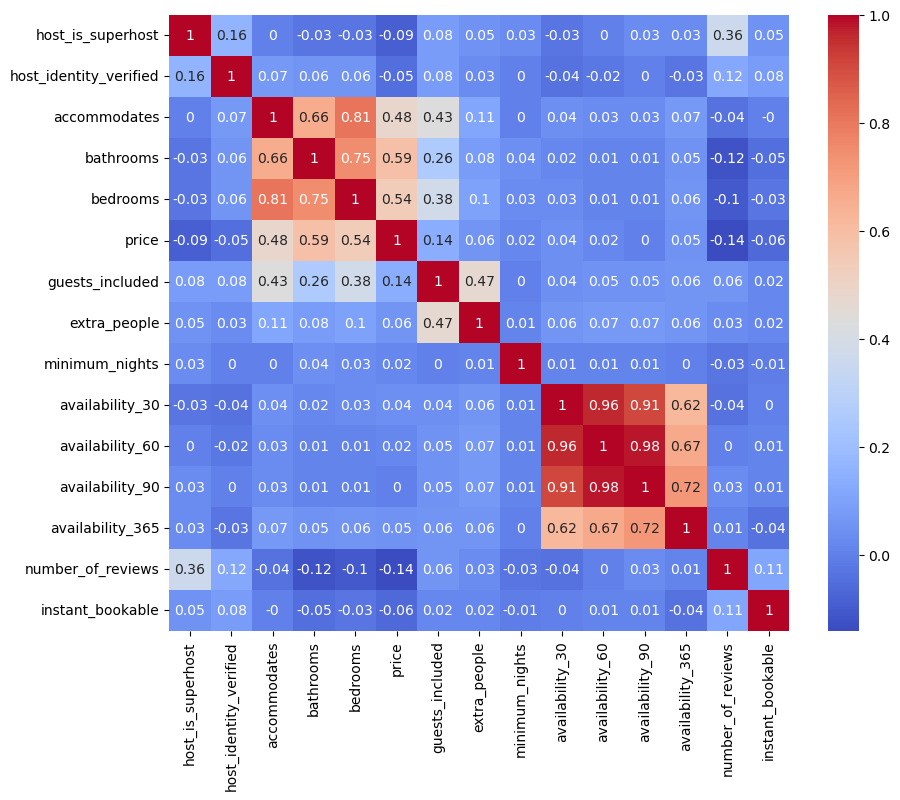

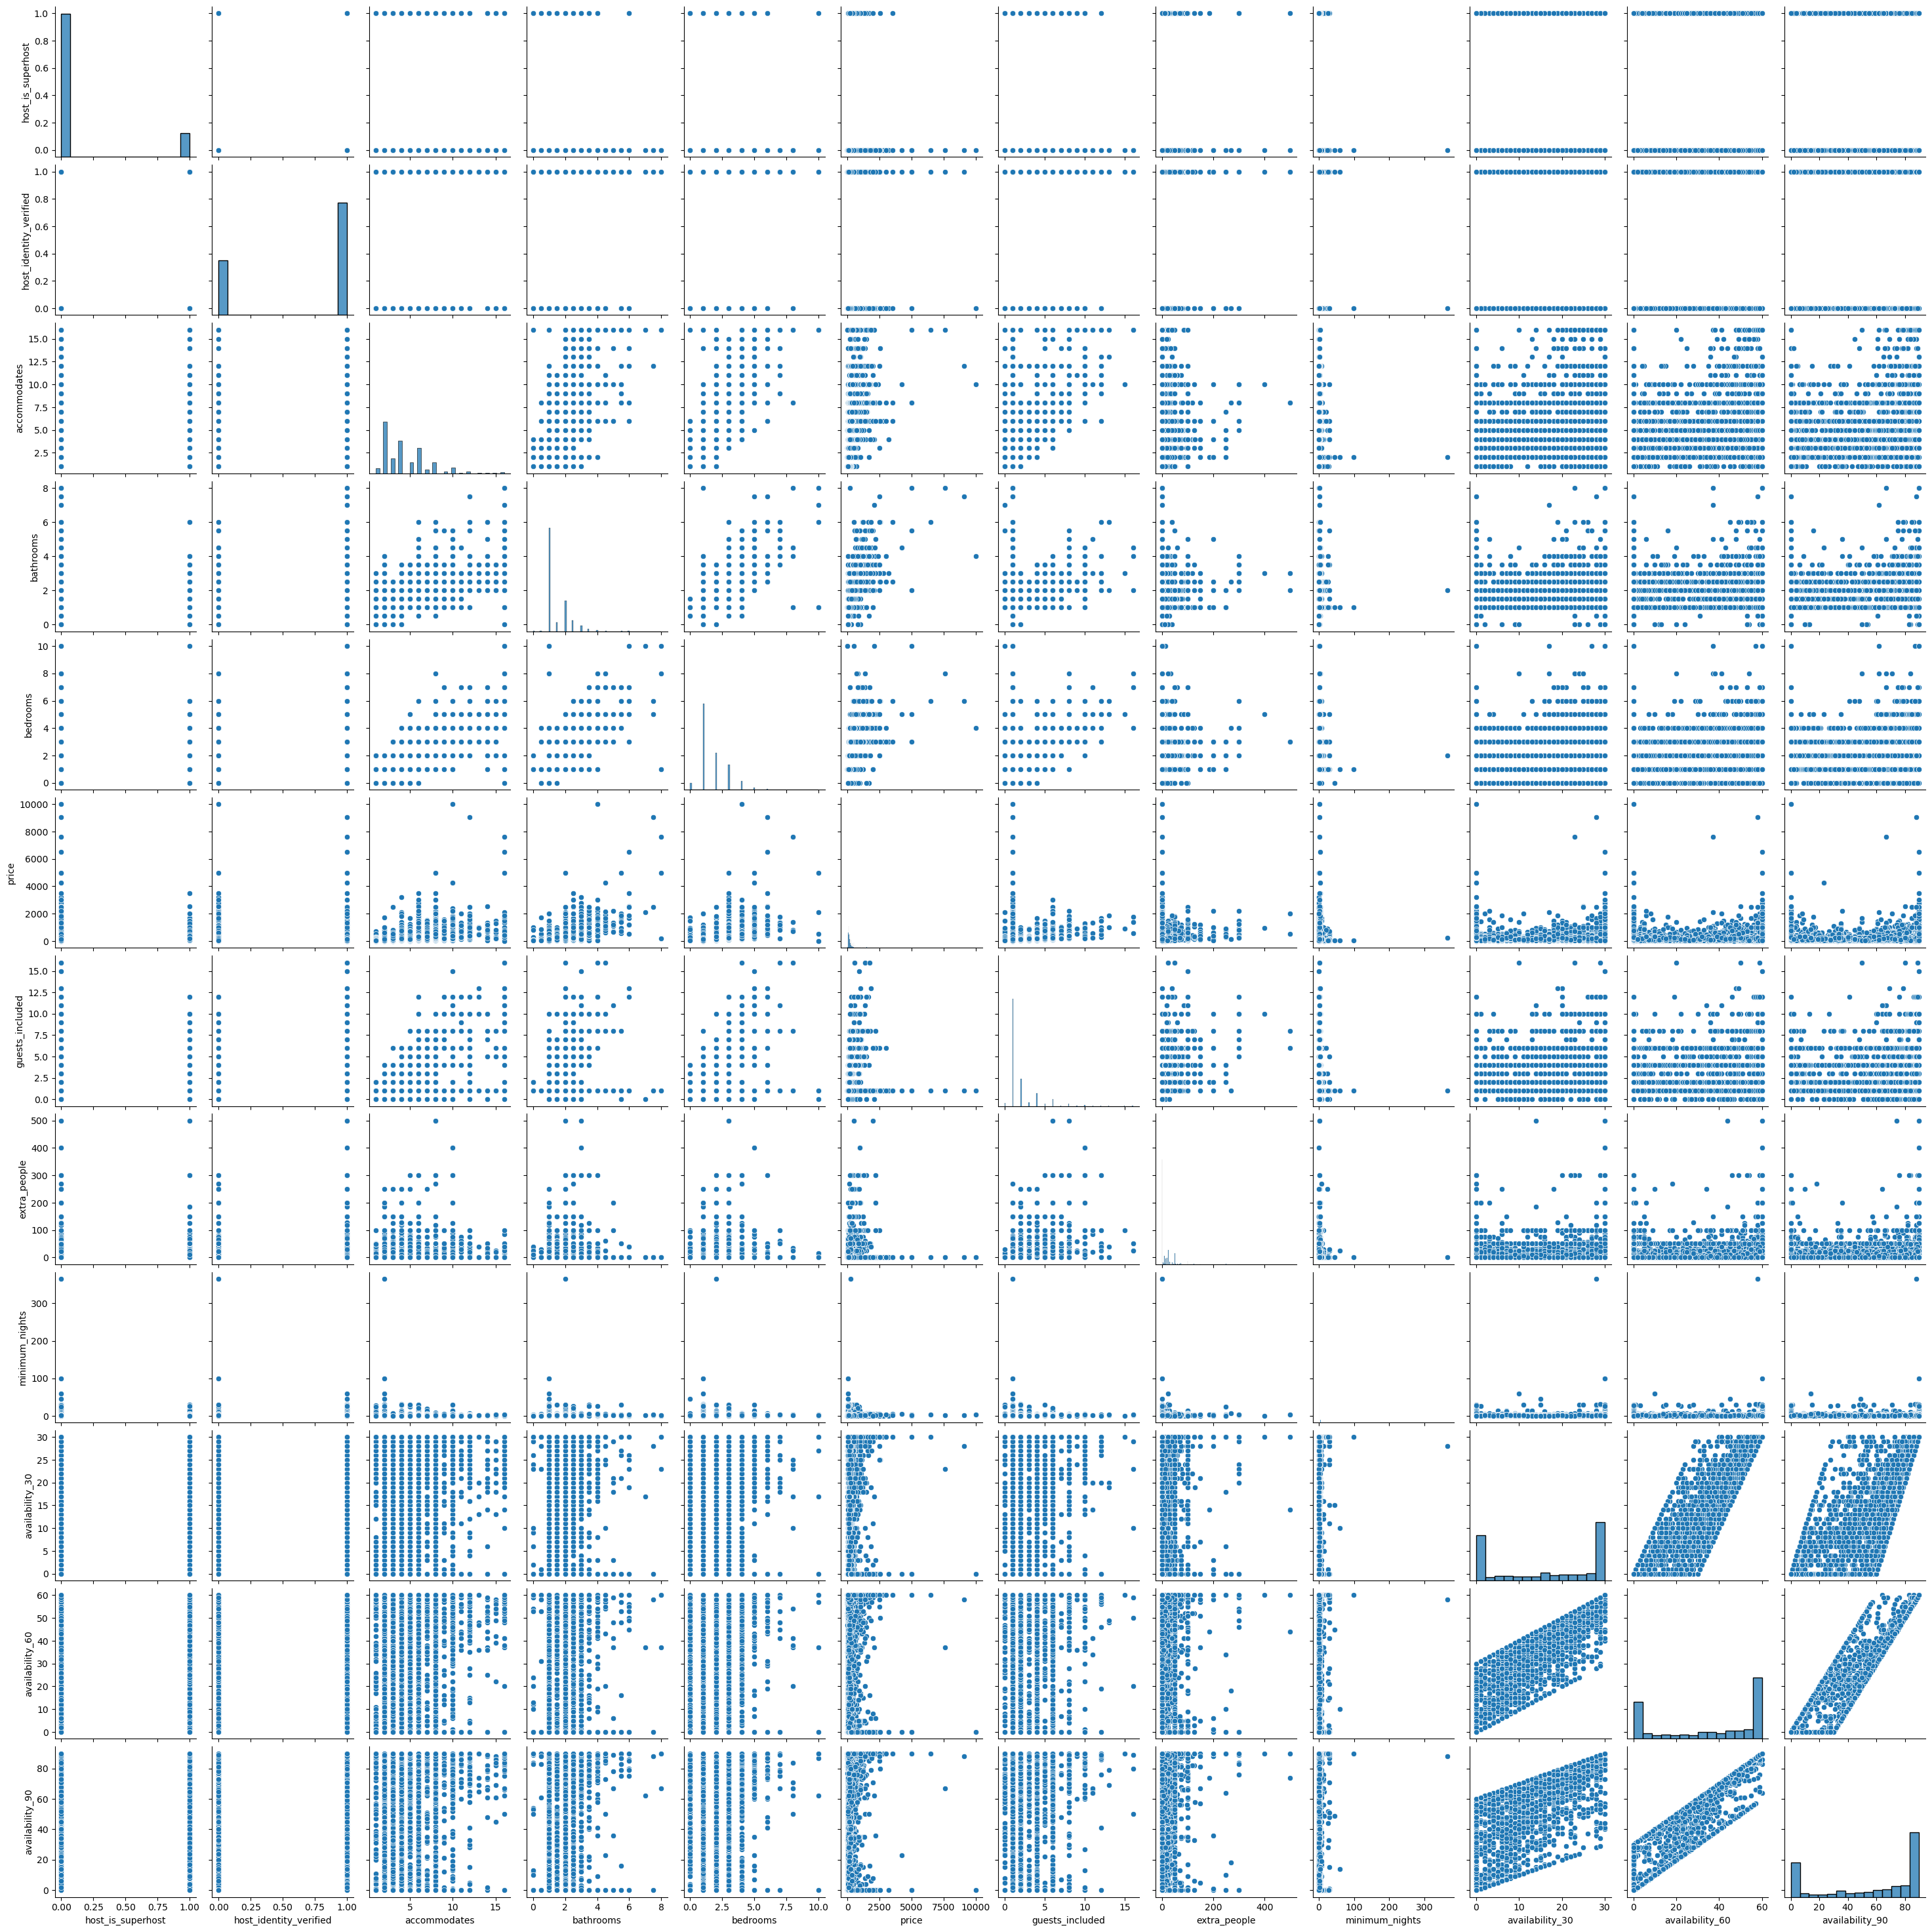

In [82]:
# Display summary statistics for numeric variables
print(ATX_lisitng_dat_num.describe())

# Compute correlations
cormat = ATX_lisitng_dat_num.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

# Create scatterplot matrix
sns.pairplot(ATX_lisitng_dat_num.iloc[:,:12])
plt.show()

In [83]:
ATX_lisitng_dat_num.dtypes

host_is_superhost           int64
host_identity_verified      int64
accommodates                int64
bathrooms                 float64
bedrooms                  float64
price                     float64
guests_included             int64
extra_people              float64
minimum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
instant_bookable            int64
dtype: object

In [84]:
ATX_lisitng_dat_num.isna().sum()/len(ATX_lisitng_dat_num)*100

host_is_superhost         0.0
host_identity_verified    0.0
accommodates              0.0
bathrooms                 0.0
bedrooms                  0.0
price                     0.0
guests_included           0.0
extra_people              0.0
minimum_nights            0.0
availability_30           0.0
availability_60           0.0
availability_90           0.0
availability_365          0.0
number_of_reviews         0.0
instant_bookable          0.0
dtype: float64

In [85]:
ATX_lisitng_dat_num.dtypes

host_is_superhost           int64
host_identity_verified      int64
accommodates                int64
bathrooms                 float64
bedrooms                  float64
price                     float64
guests_included             int64
extra_people              float64
minimum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
instant_bookable            int64
dtype: object

In [86]:
# Fit full regression
X = ATX_lisitng_dat_num.drop(columns=['price'])
y = ATX_lisitng_dat_num['price']
X = sm.add_constant(X)
fullreg = sm.OLS(y, X).fit()

# Display regression summary
print(fullreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     273.5
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:58:03   Log-Likelihood:                -41811.
No. Observations:                5835   AIC:                         8.365e+04
Df Residuals:                    5820   BIC:                         8.375e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -129

In [87]:
#Calculate Variance Inflation Factors (VIF) for full model
vifres = pd.DataFrame()
vifres["Variable"] = X.columns
vifres["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifres)


                  Variable        VIF
0                    const  11.881087
1        host_is_superhost   1.176389
2   host_identity_verified   1.055962
3             accommodates   3.159485
4                bathrooms   2.389001
5                 bedrooms   3.839645
6          guests_included   1.618175
7             extra_people   1.311761
8           minimum_nights   1.006296
9          availability_30  14.000438
10         availability_60  48.120389
11         availability_90  27.082513
12        availability_365   2.123288
13       number_of_reviews   1.208233
14        instant_bookable   1.021912


In [88]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame of numeric features
        y - vector, series of the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions

    Returns: list of selected features

    Example Call: stepwise_selection(X, y)
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included

In [89]:
selected_features  = stepwise_selection(X, y)
print('resulting features:')
print(selected_features)

Add  const with p-value 0.0000
Add  bedrooms with p-value 0.0000
Add  bathrooms with p-value 0.0000
Add  host_identity_verified with p-value 0.0000
Add  guests_included with p-value 0.0000
Add  host_is_superhost with p-value 0.0000
Add  accommodates with p-value 0.0000
Add  extra_people with p-value 0.0000
Add  number_of_reviews with p-value 0.0004
resulting features:
['const', 'bedrooms', 'bathrooms', 'host_identity_verified', 'guests_included', 'host_is_superhost', 'accommodates', 'extra_people', 'number_of_reviews']


In [90]:
# Fit stepwise regression
X = ATX_lisitng_dat_num[['host_is_superhost', 'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms', 'guests_included', 'extra_people', 'minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','number_of_reviews','instant_bookable']]
X = sm.add_constant(X)
stepreg = sm.OLS(y, X).fit()

# Display regression summary
print(stepreg.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     273.5
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:58:04   Log-Likelihood:                -41811.
No. Observations:                5835   AIC:                         8.365e+04
Df Residuals:                    5820   BIC:                         8.375e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -129

In [91]:
vifresstep = pd.DataFrame()
vifresstep["Variable"] = X.columns
vifresstep["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifresstep)

                  Variable        VIF
0                    const  11.881087
1        host_is_superhost   1.176389
2   host_identity_verified   1.055962
3             accommodates   3.159485
4                bathrooms   2.389001
5                 bedrooms   3.839645
6          guests_included   1.618175
7             extra_people   1.311761
8           minimum_nights   1.006296
9          availability_30  14.000438
10         availability_60  48.120389
11         availability_90  27.082513
12        availability_365   2.123288
13       number_of_reviews   1.208233
14        instant_bookable   1.021912


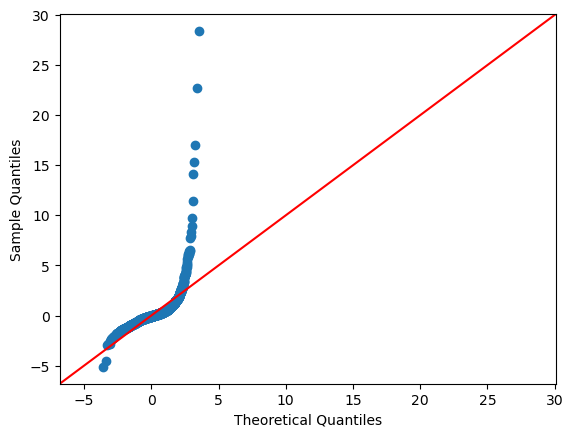

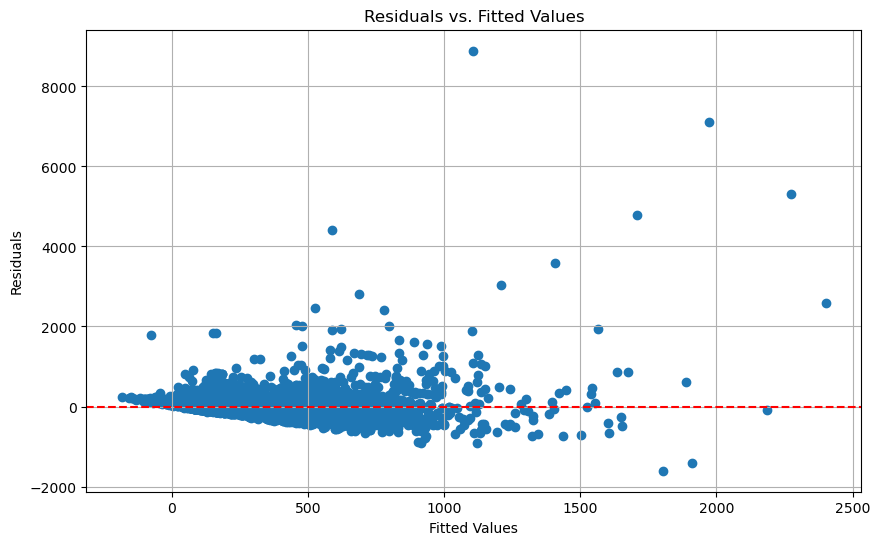

In [92]:
# Calculate residuals
residuals = stepreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals,fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(stepreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [93]:
# log transformed regression
X = ATX_lisitng_dat_num[['host_is_superhost', 'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms', 'guests_included', 'extra_people', 'minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','number_of_reviews','instant_bookable']]
X = sm.add_constant(X)
logy = np.log(y+1)
logreg = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     415.5
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:58:04   Log-Likelihood:                -5694.8
No. Observations:                5835   AIC:                         1.142e+04
Df Residuals:                    5820   BIC:                         1.152e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

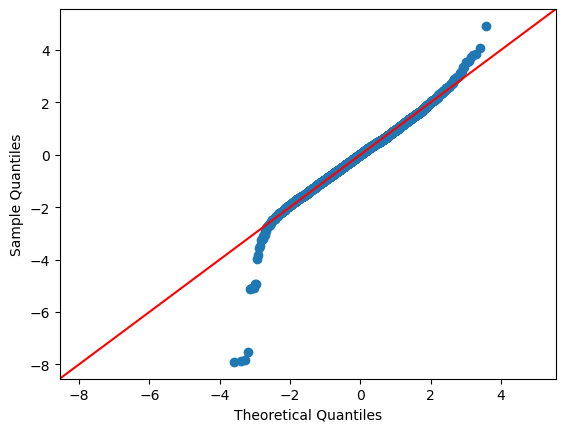

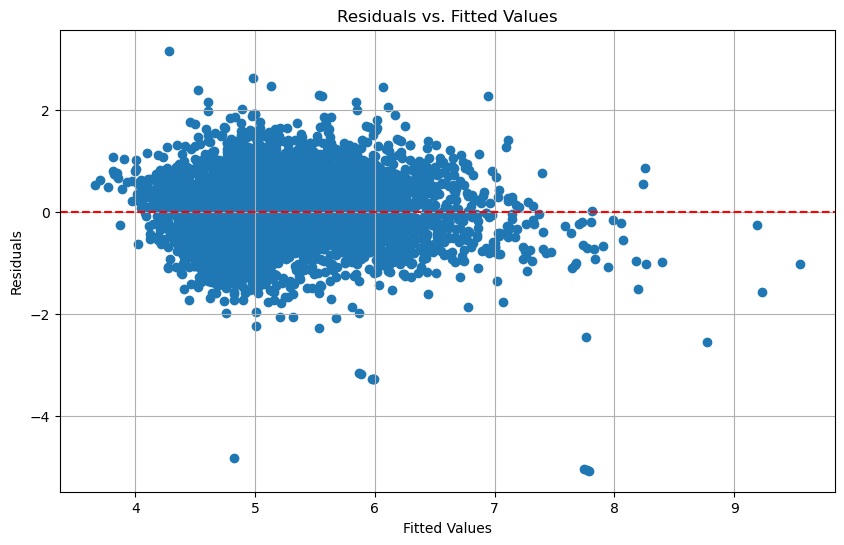

In [94]:
# Calculate residuals
residuals = logreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [95]:
# Square Root transformed regression
X = ATX_lisitng_dat_num[['host_is_superhost', 'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms','guests_included', 'extra_people', 'minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','number_of_reviews','instant_bookable']]
X = sm.add_constant(X)
sqrty = np.sqrt(y)
sqrtreg = sm.OLS(sqrty, X).fit()

# Display regression summary
print(sqrtreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     457.2
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:58:04   Log-Likelihood:                -18103.
No. Observations:                5835   AIC:                         3.624e+04
Df Residuals:                    5820   BIC:                         3.634e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

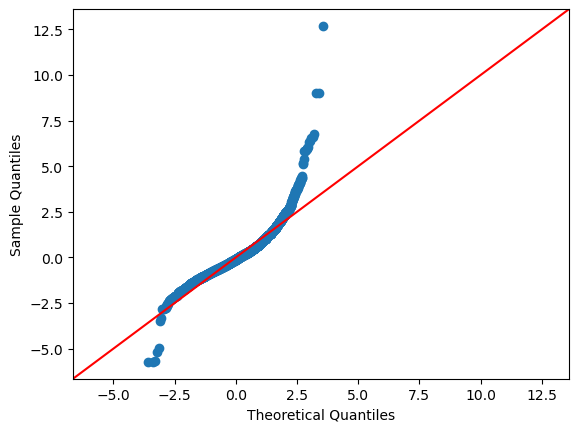

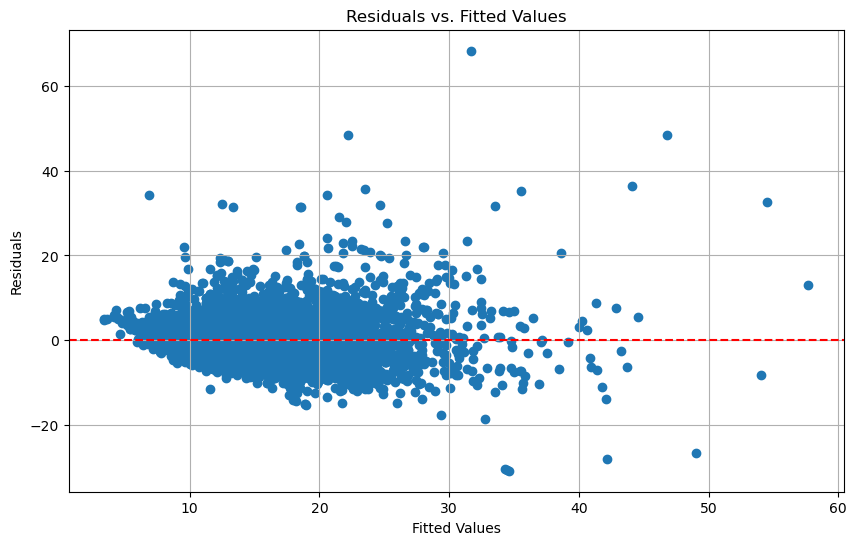

In [96]:
# Calculate residuals
residuals = sqrtreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(sqrtreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

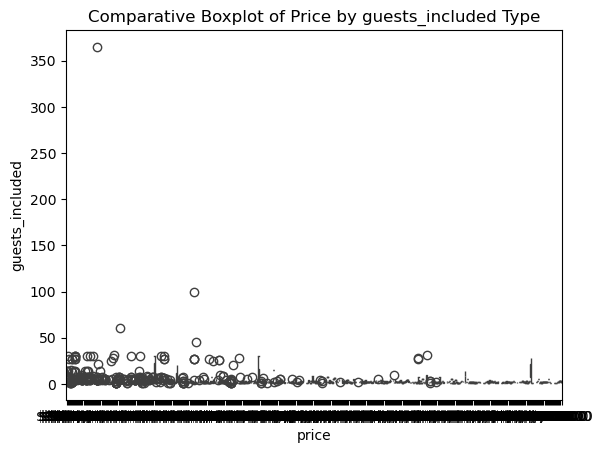

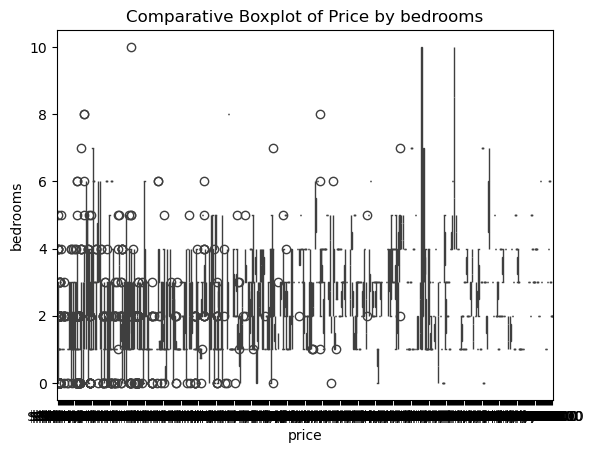

In [97]:
#Look at Building type vs Price
sns.boxplot(x="price", y="minimum_nights", data=ATX_lisitng_dat)

# Add labels and a title
plt.xlabel("price")
plt.ylabel("guests_included")
plt.title("Comparative Boxplot of Price by guests_included Type")

# Show the plot
plt.show()

#Look at Type vs Price
sns.boxplot(x="price", y="bedrooms", data=ATX_lisitng_dat)

# Add labels and a title
plt.xlabel("price")
plt.ylabel("bedrooms")
plt.title("Comparative Boxplot of Price by bedrooms")

# Show the plot
plt.show()

In [98]:
atx_num_dum = ATX_lisitng_dat_num.copy()

columns_to_add_back = ['room_type', 'bed_type', 'cancellation_policy']

columns_to_add_back = [col for col in columns_to_add_back if col in ATX_lisitng_dat.columns]

atx_num_dum[columns_to_add_back] = ATX_lisitng_dat[columns_to_add_back]

In [99]:
ATX_lisitng_dat_num.dtypes

host_is_superhost           int64
host_identity_verified      int64
accommodates                int64
bathrooms                 float64
bedrooms                  float64
price                     float64
guests_included             int64
extra_people              float64
minimum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
instant_bookable            int64
dtype: object

In [100]:
atx_num_dum.dtypes

host_is_superhost           int64
host_identity_verified      int64
accommodates                int64
bathrooms                 float64
bedrooms                  float64
price                     float64
guests_included             int64
extra_people              float64
minimum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
instant_bookable            int64
room_type                  object
bed_type                   object
cancellation_policy        object
dtype: object

In [101]:
atx_num_dum.isna().sum()/len(atx_num_dum)*100

host_is_superhost         0.0
host_identity_verified    0.0
accommodates              0.0
bathrooms                 0.0
bedrooms                  0.0
price                     0.0
guests_included           0.0
extra_people              0.0
minimum_nights            0.0
availability_30           0.0
availability_60           0.0
availability_90           0.0
availability_365          0.0
number_of_reviews         0.0
instant_bookable          0.0
room_type                 0.0
bed_type                  0.0
cancellation_policy       0.0
dtype: float64

In [102]:
atx_num_dum

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,price,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,room_type,bed_type,cancellation_policy
0,0,0,6,2.5,1.0,300.0,1,0.0,2,0,0,0,240,1,0,Private Room,Real Bed,moderate
1,0,1,2,0.0,1.0,99.0,1,0.0,3,29,59,89,364,0,0,Private Room,Futon,moderate
2,0,1,2,1.5,1.0,100.0,1,0.0,1,30,60,90,365,0,0,Private Room,Real Bed,flexible
3,0,1,2,1.5,1.0,100.0,1,0.0,1,30,60,90,365,0,0,Private Room,Real Bed,flexible
4,0,1,6,2.0,3.0,599.0,1,0.0,2,27,57,87,358,0,0,Entire Home/Apt,Real Bed,strict
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5830,1,1,4,1.0,1.0,179.0,3,50.0,1,15,45,65,340,9,0,Entire Home/Apt,Real Bed,strict
5831,0,1,2,1.0,1.0,85.0,1,5.0,2,11,36,62,316,0,0,Private Room,Real Bed,moderate
5832,0,0,2,1.0,0.0,66.0,1,22.0,2,29,59,89,364,1,1,Entire Home/Apt,Real Bed,strict
5833,0,1,1,1.0,1.0,25.0,1,0.0,1,30,60,90,365,0,0,Shared Room,Real Bed,flexible


In [103]:
min(y)

0.0

In [104]:
# log transformed regression including categorical variables
X = atx_num_dum[['host_is_superhost', 'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms', 'guests_included', 'extra_people', 'minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','number_of_reviews','instant_bookable', 'room_type','bed_type','cancellation_policy']]
X = pd.get_dummies(X, columns=['room_type','bed_type','cancellation_policy'], drop_first=True, dtype='float')
X = sm.add_constant(X)
logy = np.log(y+1)
logreg2 = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     373.3
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:58:08   Log-Likelihood:                -4994.3
No. Observations:                5835   AIC:                         1.004e+04
Df Residuals:                    5810   BIC:                         1.021e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

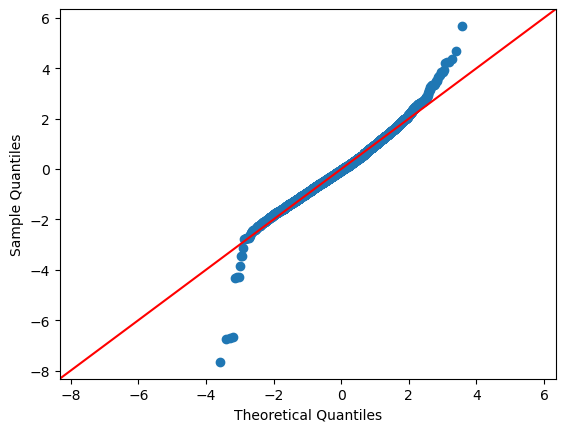

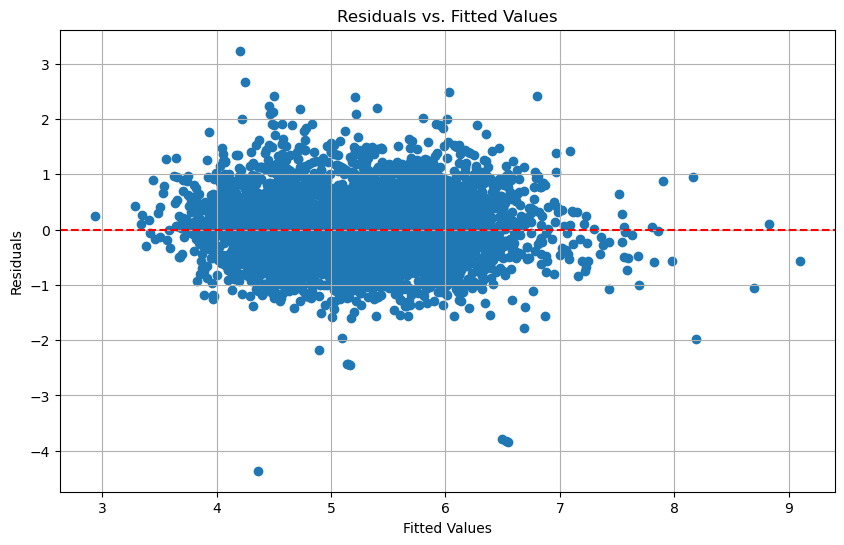

In [105]:
# Calculate residuals
residuals = logreg2.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg2.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

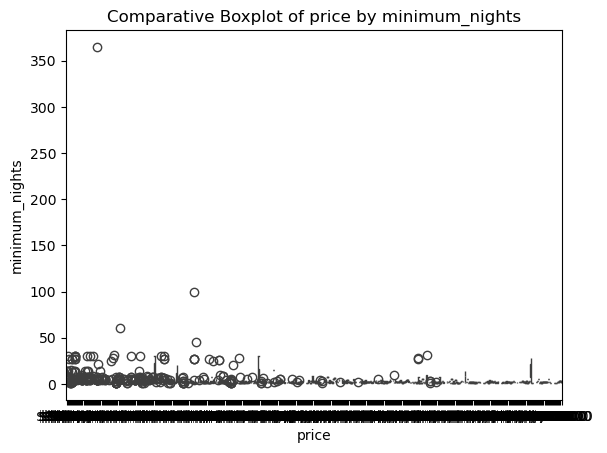

In [106]:
#Look at Make vs Price
sns.boxplot(x="price", y="minimum_nights", data=ATX_lisitng_dat)

# Add labels and a title
plt.xlabel("price")
plt.ylabel("minimum_nights")
plt.title("Comparative Boxplot of price by minimum_nights")

# Show the plot
plt.show()

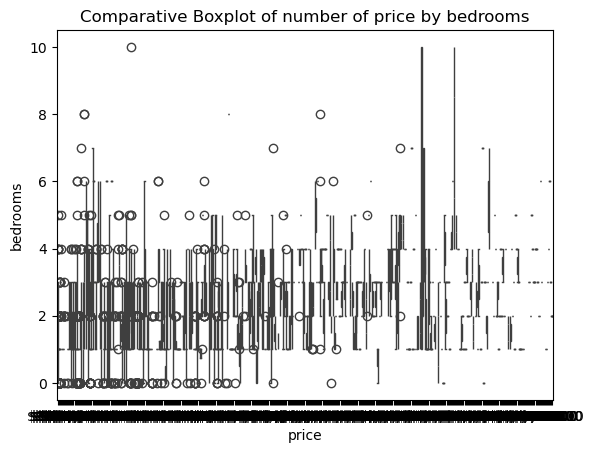

In [107]:
#Look at Type vs Price
sns.boxplot(x="price", y="bedrooms", data=ATX_lisitng_dat)

# Add labels and a title
plt.xlabel("price")
plt.ylabel("bedrooms")
plt.title("Comparative Boxplot of number of price by bedrooms")

# Show the plot
plt.show()

In [109]:
X = atx_num_dum[['host_is_superhost', 'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms', 'guests_included', 'extra_people', 'minimum_nights', 'availability_30', 'availability_60','availability_90','availability_365','number_of_reviews','instant_bookable', 'room_type','bed_type','cancellation_policy']]
X = pd.get_dummies(X, columns=['room_type','bed_type','cancellation_policy'], drop_first=True, dtype='float')
X = sm.add_constant(X)
logy = np.log(y+1)
logreg2 = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     373.3
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:58:58   Log-Likelihood:                -4994.3
No. Observations:                5835   AIC:                         1.004e+04
Df Residuals:                    5810   BIC:                         1.021e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co